In [105]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [106]:
# Image size and batch size
image_size = (224, 224)
batch_size = 16
train_dir = 'data/train'
test_dir = 'data/test'

# NEW
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

test_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False,
    subset='validation'
)


Found 570 images belonging to 3 classes.
Found 141 images belonging to 3 classes.


In [ ]:
# Build a custom CNN model
# def build_model(input_shape, num_classes):
#     model = models.Sequential([
#         # First convolution block
#         layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.2),
        
#         # Second convolution block
#         layers.Conv2D(64, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.3),
        
#         # Third convolution block
#         layers.Conv2D(128, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.4),
        
#         # Fourth convolution block
#         layers.Conv2D(256, (3, 3), activation='relu'),
#         layers.BatchNormalization(),
#         layers.MaxPooling2D((2, 2)),
#         layers.Dropout(0.5),
        
#         # Flatten and dense layers
#         layers.Flatten(),
#         layers.Dense(512, activation='relu', kernel_regularizer='l2'),
#         layers.BatchNormalization(),
#         layers.Dropout(0.5),
#         layers.Dense(num_classes, activation='softmax')
#     ])
#     return model

In [108]:
# Create model
# model = build_model((*image_size, 3), train_data.num_classes)


# base_model = tf.keras.applications.ResNet50(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(*image_size, 3)
# )
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False 

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(train_data.num_classes, activation='softmax')  # Output layer for class prediction
])


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [109]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Train the model
print("Training the custom CNN model...")
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=40,
    callbacks=[early_stop, reduce_lr]
)

# Evaluation
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
y_pred = np.argmax(y_pred_probs, axis=1)

Training the custom CNN model...


c:\Users\wongb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 327ms/step - accuracy: 0.3304 - loss: 1.2851 - val_accuracy: 0.5674 - val_loss: 0.9076 - learning_rate: 1.0000e-04
Epoch 2/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.4526 - loss: 1.0448 - val_accuracy: 0.6738 - val_loss: 0.8264 - learning_rate: 1.0000e-04
Epoch 3/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 275ms/step - accuracy: 0.6048 - loss: 0.8325 - val_accuracy: 0.7447 - val_loss: 0.7133 - learning_rate: 1.0000e-04
Epoch 4/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 283ms/step - accuracy: 0.6691 - loss: 0.7655 - val_accuracy: 0.7305 - val_loss: 0.7384 - learning_rate: 1.0000e-04
Epoch 5/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 281ms/step - accuracy: 0.7386 - loss: 0.6597 - val_accuracy: 0.7163 - val_loss: 0.6913 - learning_rate: 1.0000e-04
Epoch 6/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 290ms/step - accuracy: 0.7315 - loss: 0.6073 - val_accuracy: 0.7092 - val_loss: 0.6530 - learning_rate: 1.0000e-04
Epoch 7/40
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 314ms/step - acc

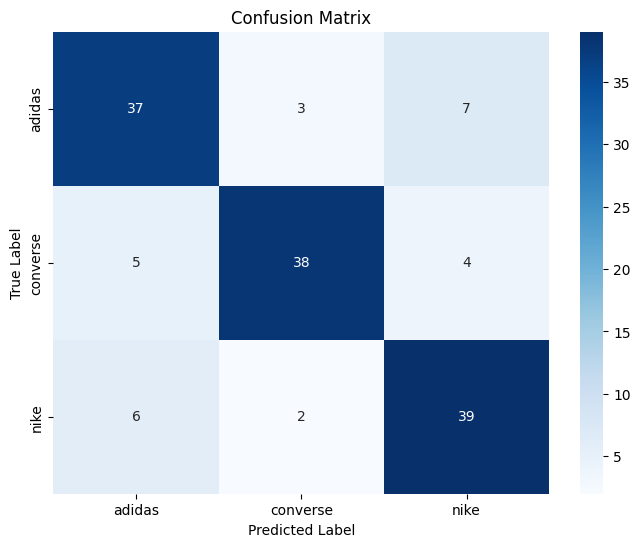

In [110]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_true, y_pred)
class_names = list(test_data.class_indices.keys())

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [111]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      adidas       0.77      0.79      0.78        47
    converse       0.88      0.81      0.84        47
        nike       0.78      0.83      0.80        47

    accuracy                           0.81       141
   macro avg       0.81      0.81      0.81       141
weighted avg       0.81      0.81      0.81       141

